In [39]:
import os

from unet import unet_model
import numpy as np
import cv2 
import tensorflow as tf
import sklearn
from sklearn.preprocessing import normalize
import glob
import matplotlib.pyplot as plt
import random

### Constants

In [2]:
WIDTH = 128
HEIGHT = 128
NUM_CLASSES = 8
beach_litter_path = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter'
images_path = beach_litter_path + '/images' # These are jpgs
masks_path = beach_litter_path + '/maskpngs' # These are pngs

### Convert image and mask data into numpy arrays

In [44]:
def data_to_numpy_arr():
    # Iterate over every file in the directory, resize, append to array
    images_arr = []
    mask_arr = []
    
    image_files = glob.glob(images_path + '/*')
    mask_files = glob.glob(masks_path + '/*')
    
    # black and white for now    
    [images_arr.append(normalize(cv2.resize(cv2.imread(image_file, 0), (HEIGHT, WIDTH)), axis=1)) for image_file in image_files]
    [mask_arr.append(normalize(cv2.resize(cv2.imread(mask_file, 0), (HEIGHT, WIDTH)), axis=1)) for mask_file in mask_files]

    return np.array(images_arr), np.array(mask_arr)

In [45]:
images_arr, mask_arr = data_to_numpy_arr()

In [46]:
print(f'Images array shape {images_arr.shape}')
print(f'Mask array shape {mask_arr.shape}')
print()
print(f'Images array type {images_arr.dtype}')
print(f'Mask array type {mask_arr.dtype}')

Images array shape (3500, 128, 128)
Mask array shape (3500, 128, 128)

Images array type float64
Mask array type float64


In [48]:
np.unique(mask_arr).shape

(1293247,)

### Visualization after processing

In [49]:
def visualize_random_image_pair():
    random_index = np.random.randint(0, len(images_arr))
    random_image = images_arr[random_index]
    random_mask = mask_arr[random_index]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 8])

    fig.suptitle('Random image and mask pair')
    ax1.imshow(random_image)
    ax2.imshow(random_mask)
    
    plt.show()
    
    # plt.imshow(random_image)
    # plt.axis('off')  # Hide axis ticks
    # plt.show()

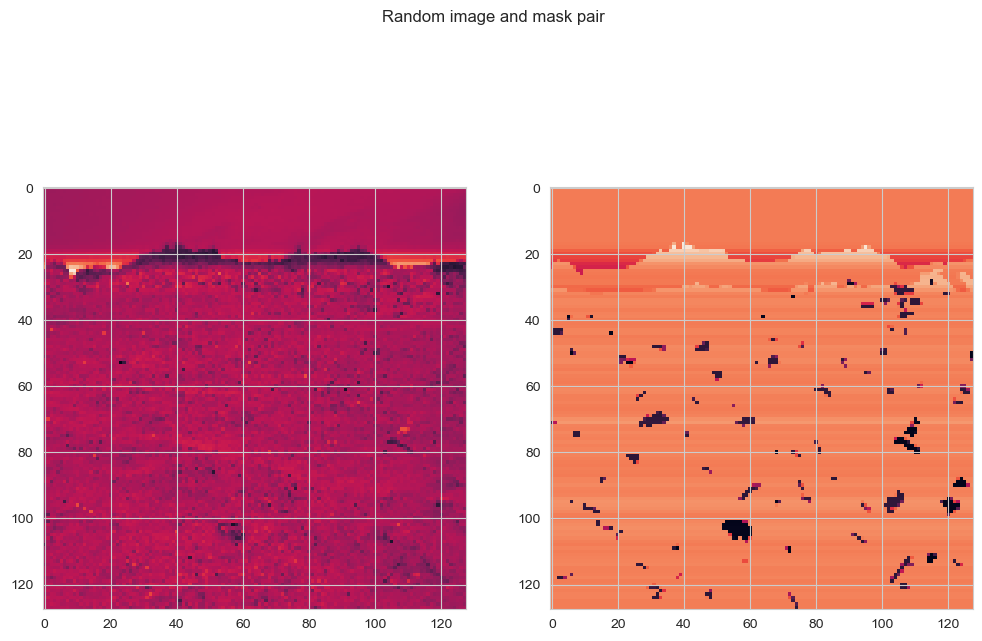

In [52]:
visualize_random_image_pair()